<a href="https://colab.research.google.com/github/Ignaciovf/timeseries_lab/blob/main/keras_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tensorflow


In [4]:
import tensorflow
tensorflow.__version__

'2.4.1'

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM


In [8]:
df=pd.read_csv('/content/VDE_daily_madrid_pollution.csv')

In [33]:
split_fraction = 0.70
# train_split = int(split_fraction * int(df.shape[0]))
train_split = int(1031)
step = 6

past = 1000
future = 100
learning_rate = 0.001
batch_size = 200
epochs = 10
start = past + future
end = start + train_split
print('start: ', start)
print('end: ', end)
print('Train Split: ',train_split)
print('dataframe shape ',df.shape)

start:  1100
end:  2131
Train Split:  1031
dataframe shape  (2191, 24)


In [34]:

def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

feature_keys=df.columns

selected_features = ['SEASON','month', 'HUMIDITY',
       'WIND_SPEED', 'PRECIPITAITON', 'COMMULATIVE_PRECIPITATION']
features = df[selected_features]
features.index = df['Date']
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]




x_train = train_data[[i for i in range(len(features.columns))]].values
y_train = features.iloc[start:end][[1]]



In [36]:
print(x_train)

[[ 1.40677552 -1.57064498 -0.65685732  0.08850767 -0.39217232 -0.39518715]
 [ 1.40677552 -1.57064498  0.96928351  0.60395627 -0.39217232 -0.39518715]
 [ 1.40677552 -1.57064498  1.24666161  1.60115531  2.61845889  2.45096503]
 ...
 [ 0.5109228   1.14079962  0.93143432 -1.35597053 -0.39217232 -0.39518715]
 [ 0.5109228   1.14079962  1.35742872 -1.28659186 -0.39217232 -0.39518715]
 [ 0.5109228   1.14079962  0.17722564  0.6020256  -0.39217232 -0.39518715]]


In [38]:

sequence_length = int(past / step)

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
    )

x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(len(features.columns))]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)


Input shape: (36, 166, 6)
Target shape: (36, 1)


In [44]:

model = Sequential()
model.add(LSTM(32, input_shape=(10, 64)))

inputs = keras.layers.Input(shape=(x_train.shape[0], x_train.shape[1]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1031, 6)]         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                4992      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
1/1 [==============================] - 0s 159ms/step - loss: 0.2133
Epoch 2/10
1/1 [==============================] - 0s 155ms/step - loss: 0.1488
Epoch 3/10
1/1 [==============================] - 0s 147ms/step - loss: 0.0996
Epoch 4/10
1/1 [==============================] - 0s 159ms/step - loss: 0.0680
Epoch 5/10
1/1 [==============================] - 0s 140ms/step - loss: 0.0549
Epoch 6/10
1/1 [==============================] - 0s 165ms/step - loss: 0.0589
Epoch 7/10
1/1 [==============================] - 0s 134ms/step - loss: 0.0758
Epoch 8/10
1/1 [==============================] - 0s 177ms/step - loss: 0.0983
Epoch 9/10
1/1 [==============================] - 0s 152ms/step - loss: 0.1185
Epoch 10/10
1/1 [==============================] - 0s 143ms/step - loss: 0.1312


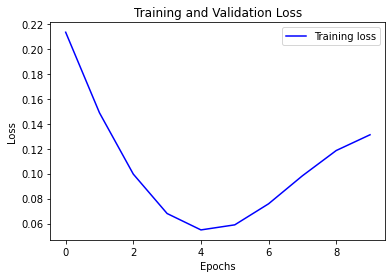

In [51]:

path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

def visualize_loss(history, title):
    loss = history.history["loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")


In [54]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


In [58]:
for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

this should work


In [61]:
model.predict(1)

IndexError: ignored